# Hierarchical Clustering for Spatial Location Analysis

This notebook implements hierarchical clustering based on geographic location, similar to the K-means approach but with hierarchical structure.

**Benefits of Hierarchical Clustering:**
1. **Dendrogram visualization** - See the hierarchy of location groupings
2. **Flexible k selection** - Can "cut" the tree at any level
3. **Nested structure** - Understand relationships between clusters
4. **Agglomerative approach** - Bottom-up merging of similar locations

**Use Cases:**
- Identify district/neighborhood hierarchies
- Understand urban structure at multiple scales
- Create nested geographic zones (city → district → neighborhood)

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import pickle
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


## 2. Configuration

In [2]:
# File paths
DATA_FILE = '../datos/filtered_amss/sv_12_2023_location_features_amss.csv'
OUTPUT_DIR = 'results_hierarchical'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')

# Hierarchical clustering parameters
LINKAGE_METHOD = 'ward'  # Options: 'ward', 'complete', 'average', 'single'
DISTANCE_METRIC = 'euclidean'  # For ward, must be euclidean
OPTIMAL_K = 3  # For business rules, or None to auto-detect
MIN_VISITORS = 5  # Minimum unique visitors to include location

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Configuration:")
print(f"  Data file: {DATA_FILE}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Linkage method: {LINKAGE_METHOD}")
print(f"  Target clusters: {OPTIMAL_K if OPTIMAL_K else 'Auto-detect'}")

Configuration:
  Data file: ../datos/filtered_amss/sv_12_2023_location_features_amss.csv
  Output directory: results_hierarchical
  Linkage method: ward
  Target clusters: 3


## 3. Load Data

In [3]:
# Load data
df = pd.read_csv(DATA_FILE)

print(f"Data loaded: {len(df):,} places")
print(f"Features: {len(df.columns)} columns")

# Filter by minimum visitors
df_filtered = df[df['unique_devices_count'] >= MIN_VISITORS].copy()

print(f"\nAfter filtering (>= {MIN_VISITORS} visitors): {len(df_filtered):,} places")
df_filtered.head()

Data loaded: 14,697 places
Features: 65 columns

After filtering (>= 5 visitors): 7,260 places


osm_id        clase            nombre  \
0  400846765         bank  Banco Industrial   
1  400002511  residential         Palo Alto   
2  556395539      parking           parking   
3  664504345        grass             grass   
4  312566571     building             Fusal   

                                        geometry_wkt  unique_visits_weekday  \
0  POLYGON ((-89.2383563 13.6947575, -89.238334 1...                     12   
1  POLYGON ((-89.2576736 13.7101421, -89.2571881 ...                     17   
2  POLYGON ((-89.2001489 13.7046549, -89.200128 1...                     12   
3  POLYGON ((-89.2407758 13.7197677, -89.2406638 ...                     12   
4  POLYGON ((-89.2578833 13.6617643, -89.2577445 ...                      9   

   footfall_avg_per_day  unique_devices_count  \
0              1.714286                     9   
1              1.411765                    15   
2              1.300000                    11   
3              1.153846                    14   
4              1.153846                    14   

   unique_device_by_timeblock_morning  unique_device_by_timeblock_afternoon  \
0                                   4                                     7   
1                                   2                                     7   
2                                   8                                     4   
3                                   4                                     8   
4                                   5                                     6   

   unique_device_by_timeblock_evening  ...  dwell_time_median  \
0                                   1  ...                0.0   
1                                  10  ...                0.0   
2                                   0  ...                0.0   
3                                   2  ...                0.0   
4                                   4  ...                0.0   

   dwell_time_weekday_mean  dwell_time_weekend_mean  days_active  \
0                10.112500                      NaN            7   
1                48.552941                41.983333           17   
2                 0.033333                 0.000000           10   
3                 0.000000                 0.000000           13   
4                 0.000000                 5.975000           13   

   avg_visits_per_active_day  std_visits_per_day  weekend_to_weekday_ratio  \
0                   4.000000            3.366502                  0.000000   
1                   4.000000            4.415880                  0.411765   
2                   1.400000            0.699206                  0.083333   
3                   1.153846            0.375534                  0.250000   
4                   1.769231            1.363442                  0.666667   

   morning_to_evening_ratio  repeat_to_unique_ratio  avg_visits_per_device  
0                      4.00                2.111111               3.111111  
1                      0.20                3.533333               4.533333  
2                       NaN                0.272727               1.272727  
3                      2.00                0.071429               1.071429  
4                      1.25                0.642857               1.642857  

[5 rows x 65 columns]

## 4. Extract Geographic Features

For location-based clustering, we'll extract centroid coordinates from geometries.

In [4]:
from shapely import wkt

def extract_centroid(geometry_wkt):
    """Extract centroid (lat, lon) from WKT geometry."""
    try:
        geom = wkt.loads(geometry_wkt)
        centroid = geom.centroid
        return centroid.y, centroid.x  # lat, lon
    except:
        return None, None

# Extract centroids
print("Extracting centroids from geometries...")
df_filtered[['latitude', 'longitude']] = df_filtered['geometry_wkt'].apply(
    lambda x: pd.Series(extract_centroid(x))
)

# Remove any invalid geometries
df_filtered = df_filtered.dropna(subset=['latitude', 'longitude'])

print(f"\n✓ {len(df_filtered):,} places with valid coordinates")
print(f"Latitude range: {df_filtered['latitude'].min():.6f} to {df_filtered['latitude'].max():.6f}")
print(f"Longitude range: {df_filtered['longitude'].min():.6f} to {df_filtered['longitude'].max():.6f}")

Extracting centroids from geometries...

✓ 7,260 places with valid coordinates
Latitude range: 13.550097 to 13.890260
Longitude range: -89.350379 to -89.098645


## 5. Prepare Feature Matrix

We'll use geographic coordinates plus key behavioral features.

In [5]:
# Define features for clustering
GEOGRAPHIC_FEATURES = [
    'latitude',
    'longitude'
]

# Optional: Add behavioral features for richer clustering
BEHAVIORAL_FEATURES = [
    'unique_devices_count',
    'footfall_avg_per_day',
    'recurrence_rate',
    'dwell_time_mean',
    'entropy_hourly_pattern'
]

# Choose features: Geographic only or Geographic + Behavioral
USE_BEHAVIORAL = True  # Set to False for pure spatial clustering

if USE_BEHAVIORAL:
    CLUSTERING_FEATURES = GEOGRAPHIC_FEATURES + BEHAVIORAL_FEATURES
else:
    CLUSTERING_FEATURES = GEOGRAPHIC_FEATURES

print(f"Using {len(CLUSTERING_FEATURES)} features:")
for f in CLUSTERING_FEATURES:
    print(f"  - {f}")

# Extract feature matrix
X = df_filtered[CLUSTERING_FEATURES].copy()

# Handle missing values
X = X.fillna(X.median())

print(f"\n✓ Feature matrix: {X.shape}")

Using 7 features:
  - latitude
  - longitude
  - unique_devices_count
  - footfall_avg_per_day
  - recurrence_rate
  - dwell_time_mean
  - entropy_hourly_pattern

✓ Feature matrix: (7260, 7)


## 6. Feature Scaling

Critical for hierarchical clustering to avoid feature dominance.

In [6]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Features standardized")
print(f"  Shape: {X_scaled.shape}")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")

✓ Features standardized
  Shape: (7260, 7)
  Mean: -0.000000
  Std: 1.000000


## 7. Hierarchical Clustering

### 7.1 Compute Linkage Matrix

In [7]:
print("="*70)
print("COMPUTING HIERARCHICAL CLUSTERING")
print("="*70)
print(f"\nLinkage method: {LINKAGE_METHOD}")
print(f"Distance metric: {DISTANCE_METRIC}")
print(f"Number of observations: {len(X_scaled):,}")
print("\nThis may take a few minutes for large datasets...\n")

# Compute linkage matrix
linkage_matrix = linkage(X_scaled, method=LINKAGE_METHOD, metric=DISTANCE_METRIC)

print("✓ Linkage matrix computed!")
print(f"  Shape: {linkage_matrix.shape}")
print(f"  Max distance: {linkage_matrix[:, 2].max():.2f}")

COMPUTING HIERARCHICAL CLUSTERING

Linkage method: ward
Distance metric: euclidean
Number of observations: 7,260

This may take a few minutes for large datasets...

✓ Linkage matrix computed!
  Shape: (7259, 4)
  Max distance: 131.03


### 7.2 Dendrogram Visualization

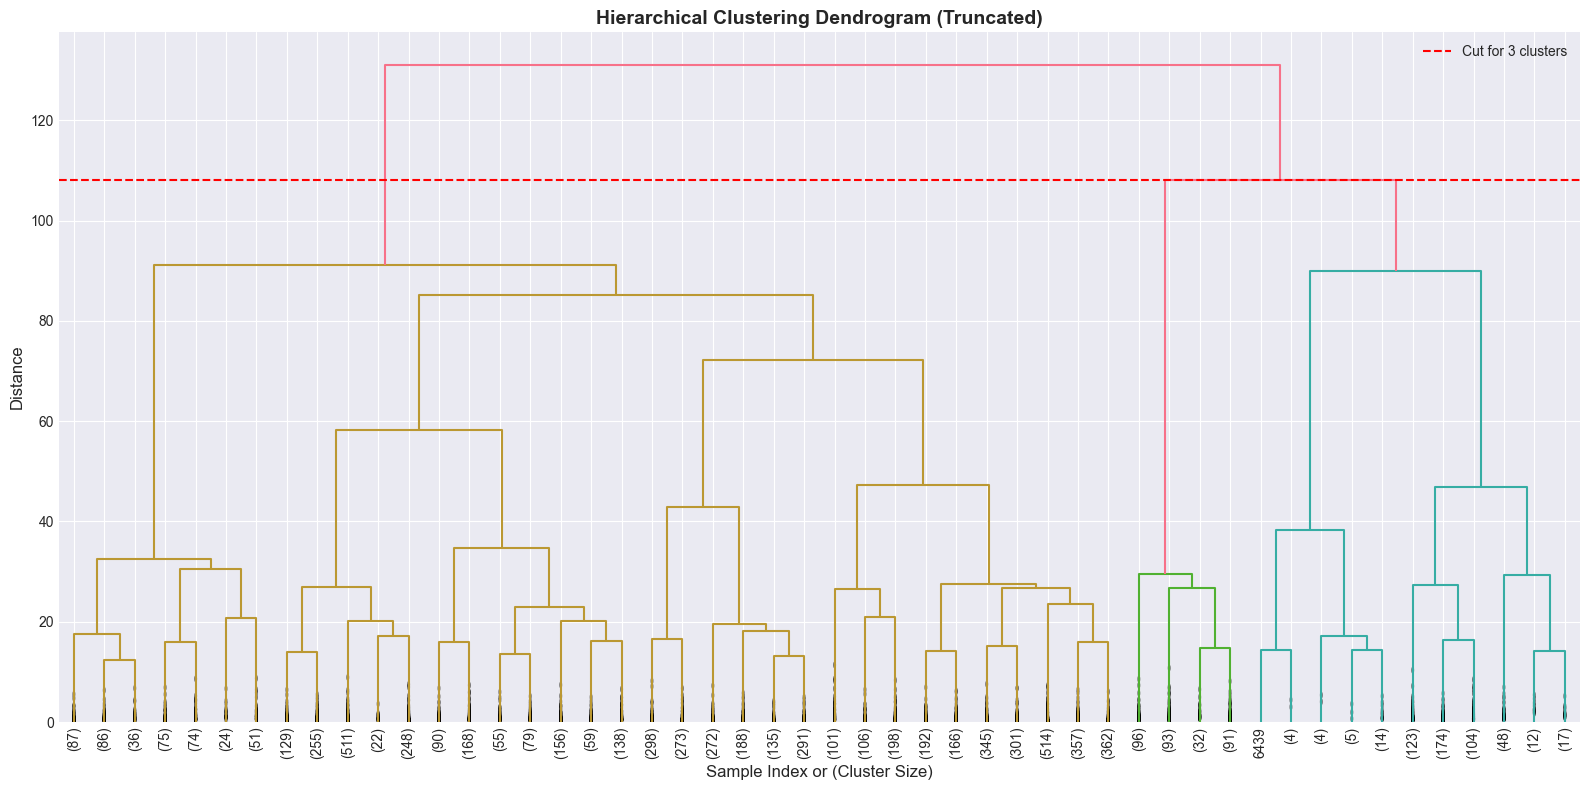

✓ Saved: results_hierarchical/dendrogram_truncated.png


In [8]:
# Full dendrogram (truncated for visualization)
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Show only last p merged clusters
    p=50,  # Show last 50 merges
    leaf_font_size=10,
    show_contracted=True
)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title('Hierarchical Clustering Dendrogram (Truncated)', 
          fontsize=14, fontweight='bold')
plt.axhline(y=linkage_matrix[-OPTIMAL_K+1, 2] if OPTIMAL_K else 0, 
            c='r', linestyle='--', label=f'Cut for {OPTIMAL_K} clusters')
plt.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/dendrogram_truncated.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/dendrogram_truncated.png")

### 7.3 Determine Optimal Number of Clusters

In [9]:
# If OPTIMAL_K not specified, find it automatically
if OPTIMAL_K is None:
    print("Finding optimal number of clusters...\n")
    
    k_range = range(2, 11)
    silhouettes = []
    davies_bouldins = []
    calinski_harabaszs = []
    
    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        sil = silhouette_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        
        silhouettes.append(sil)
        davies_bouldins.append(db)
        calinski_harabaszs.append(ch)
        
        print(f"K={k}: Silhouette={sil:.4f}, DB={db:.4f}, CH={ch:.2f}")
    
    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (K)')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette Score (Higher = Better)')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(k_range, davies_bouldins, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (K)')
    axes[1].set_ylabel('Davies-Bouldin Index')
    axes[1].set_title('Davies-Bouldin Index (Lower = Better)')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(k_range, calinski_harabaszs, 'mo-', linewidth=2, markersize=8)
    axes[2].set_xlabel('Number of Clusters (K)')
    axes[2].set_ylabel('Calinski-Harabasz Index')
    axes[2].set_title('Calinski-Harabasz Index (Higher = Better)')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/optimal_k_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Select optimal K
    OPTIMAL_K = k_range[np.argmax(silhouettes)]
    print(f"\n✓ Optimal K selected: {OPTIMAL_K}")
else:
    print(f"Using specified K = {OPTIMAL_K}")

Using specified K = 3


## 8. Extract Final Clusters

In [10]:
# Cut dendrogram to get k clusters
cluster_labels = fcluster(linkage_matrix, OPTIMAL_K, criterion='maxclust')

# Convert to 0-indexed
cluster_labels = cluster_labels - 1

# Add to dataframe
df_filtered['cluster'] = cluster_labels

print("✓ Clusters assigned!")
print(f"\nCluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = 100 * count / len(cluster_labels)
    print(f"  Cluster {cluster_id}: {count:4d} places ({pct:5.2f}%)")

✓ Clusters assigned!

Cluster distribution:
  Cluster 0: 6442 places (88.73%)
  Cluster 1:  312 places ( 4.30%)
  Cluster 2:  506 places ( 6.97%)


## 9. Evaluate Clustering Quality

In [11]:
# Calculate evaluation metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_db = davies_bouldin_score(X_scaled, cluster_labels)
final_ch = calinski_harabasz_score(X_scaled, cluster_labels)

print("="*70)
print("CLUSTERING QUALITY EVALUATION")
print("="*70)
print(f"\nNumber of Clusters: {OPTIMAL_K}")
print(f"Number of Places: {len(cluster_labels):,}")
print(f"\nMetrics:")
print(f"  Silhouette Score:        {final_silhouette:.4f}")

if final_silhouette > 0.7:
    print(f"    → Excellent clustering quality")
elif final_silhouette > 0.5:
    print(f"    → Good clustering quality")
elif final_silhouette > 0.25:
    print(f"    → Acceptable clustering quality")
else:
    print(f"    → Weak clustering structure")

print(f"\n  Davies-Bouldin Index:    {final_db:.4f}")
print(f"    → Lower is better")

print(f"\n  Calinski-Harabasz Index: {final_ch:.2f}")
print(f"    → Higher is better")
print("="*70)

CLUSTERING QUALITY EVALUATION

Number of Clusters: 3
Number of Places: 7,260

Metrics:
  Silhouette Score:        0.4290
    → Acceptable clustering quality

  Davies-Bouldin Index:    1.1205
    → Lower is better

  Calinski-Harabasz Index: 1437.47
    → Higher is better


## 10. Spatial Visualization

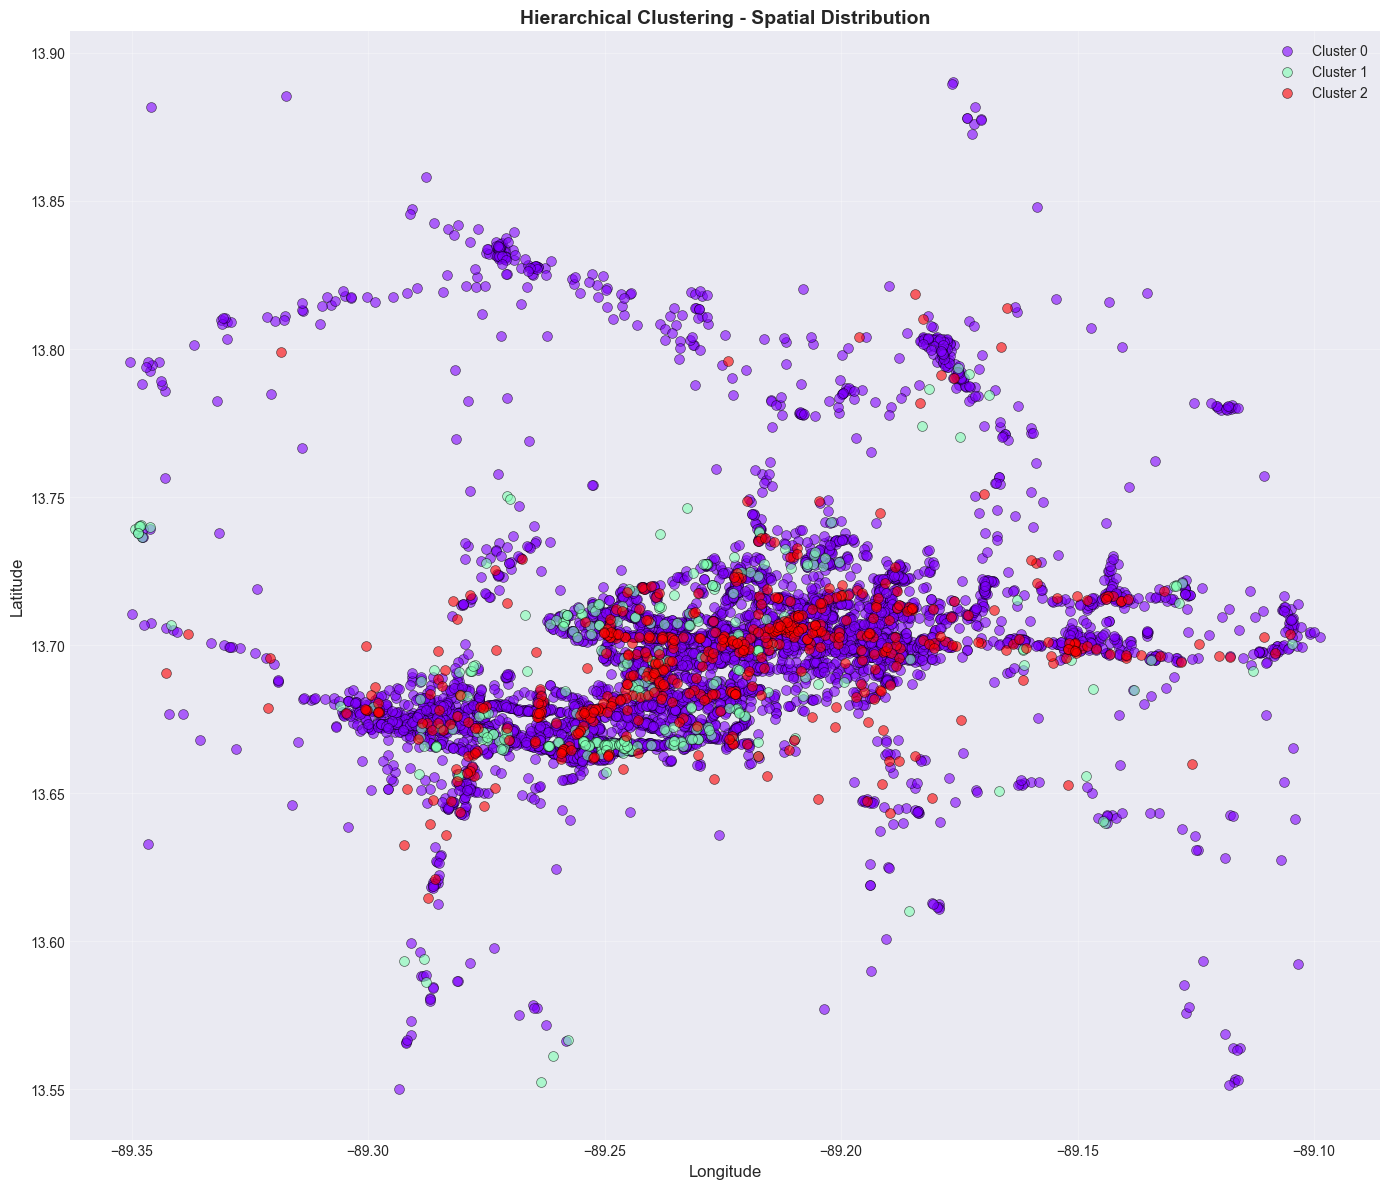

✓ Saved: results_hierarchical/spatial_clusters_map.png


In [12]:
# Create color map
colors = plt.cm.rainbow(np.linspace(0, 1, OPTIMAL_K))

fig, ax = plt.subplots(figsize=(14, 12))

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    ax.scatter(cluster_data['longitude'], cluster_data['latitude'],
              c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
              alpha=0.6, s=50, edgecolors='black', linewidths=0.5)

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Hierarchical Clustering - Spatial Distribution', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/spatial_clusters_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/spatial_clusters_map.png")

## 11. Cluster Profiling

In [13]:
# Geographic characteristics
print("="*70)
print("CLUSTER PROFILES")
print("="*70)

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    print(f"\n{'─'*70}")
    print(f"Cluster {cluster_id} ({len(cluster_data):,} places)")
    print(f"{'─'*70}")
    
    # Geographic center
    center_lat = cluster_data['latitude'].mean()
    center_lon = cluster_data['longitude'].mean()
    print(f"\nGeographic Center: ({center_lat:.6f}, {center_lon:.6f})")
    
    # Spatial extent
    lat_range = cluster_data['latitude'].max() - cluster_data['latitude'].min()
    lon_range = cluster_data['longitude'].max() - cluster_data['longitude'].min()
    print(f"Spatial Extent: {lat_range:.4f}° lat × {lon_range:.4f}° lon")
    
    # Top place types
    print(f"\nTop place types:")
    top_types = cluster_data['clase'].value_counts().head(5)
    for place_type, count in top_types.items():
        pct = 100 * count / len(cluster_data)
        print(f"  {place_type:20s}: {count:3d} ({pct:5.1f}%)")
    
    # Behavioral characteristics (if available)
    if USE_BEHAVIORAL:
        print(f"\nBehavioral Characteristics:")
        print(f"  Avg unique visitors:  {cluster_data['unique_devices_count'].mean():8.1f}")
        print(f"  Avg footfall/day:     {cluster_data['footfall_avg_per_day'].mean():8.2f}")
        print(f"  Avg recurrence rate:  {cluster_data['recurrence_rate'].mean():8.2%}")
        print(f"  Avg dwell time:       {cluster_data['dwell_time_mean'].mean():8.1f} min")
    
    # Example places
    print(f"\nExample places:")
    examples = cluster_data.nlargest(3, 'unique_devices_count')[['nombre', 'clase', 'unique_devices_count']]
    for idx, row in examples.iterrows():
        if pd.notna(row['nombre']) and row['nombre'].strip():
            print(f"  - {row['nombre']} ({row['clase']}) - {int(row['unique_devices_count'])} visitors")
        else:
            print(f"  - {row['clase']} - {int(row['unique_devices_count'])} visitors")

print("\n" + "="*70)

CLUSTER PROFILES

──────────────────────────────────────────────────────────────────────
Cluster 0 (6,442 places)
──────────────────────────────────────────────────────────────────────

Geographic Center: (13.698543, -89.228639)
Spatial Extent: 0.3402° lat × 0.2517° lon

Top place types:
  building            : 2981 ( 46.3%)
  parking             : 480 (  7.5%)
  grass               : 300 (  4.7%)
  residential         : 277 (  4.3%)
  park                : 206 (  3.2%)

Behavioral Characteristics:
  Avg unique visitors:      24.0
  Avg footfall/day:         1.80
  Avg recurrence rate:    14.80%
  Avg dwell time:           37.4 min

Example places:
  - parking (parking) - 351 visitors
  - grass (grass) - 325 visitors
  - Plaza Mundo Apopa (mall) - 321 visitors

──────────────────────────────────────────────────────────────────────
Cluster 1 (312 places)
──────────────────────────────────────────────────────────────────────

Geographic Center: (13.688933, -89.241347)
Spatial Extent: 0.2

## 12. Multi-Level Analysis (Hierarchical Structure)

One advantage of hierarchical clustering is we can analyze multiple levels.

In [14]:
# Extract clusters at multiple levels
levels = [2, 3, 5, 8, 10]

print("="*70)
print("MULTI-LEVEL HIERARCHICAL STRUCTURE")
print("="*70)

for k in levels:
    labels_k = fcluster(linkage_matrix, k, criterion='maxclust') - 1
    
    # Calculate silhouette
    sil_k = silhouette_score(X_scaled, labels_k)
    
    # Cluster sizes
    sizes_k = pd.Series(labels_k).value_counts().sort_index()
    
    print(f"\nLevel K={k}: Silhouette={sil_k:.4f}")
    print(f"  Cluster sizes: {sizes_k.tolist()}")
    print(f"  Mean size: {sizes_k.mean():.1f}, Std: {sizes_k.std():.1f}")

print("\n" + "="*70)

MULTI-LEVEL HIERARCHICAL STRUCTURE

Level K=2: Silhouette=0.4393
  Cluster sizes: [6442, 818]
  Mean size: 3630.0, Std: 3976.8

Level K=3: Silhouette=0.4290
  Cluster sizes: [6442, 312, 506]
  Mean size: 2420.0, Std: 3484.5

Level K=5: Silhouette=0.3763
  Cluster sizes: [433, 6009, 312, 28, 478]
  Mean size: 1452.0, Std: 2553.5

Level K=8: Silhouette=0.1756
  Cluster sizes: [433, 1165, 745, 1457, 2642, 312, 28, 478]
  Mean size: 907.5, Std: 840.1

Level K=10: Silhouette=0.1841
  Cluster sizes: [433, 1165, 745, 1457, 405, 2237, 312, 28, 401, 77]
  Mean size: 726.0, Std: 698.0



## 13. Compare with K-means

In [15]:
# Load K-means results if available
kmeans_file = 'results/kmeans_clustered_places.csv'

if os.path.exists(kmeans_file):
    print("="*70)
    print("COMPARISON: HIERARCHICAL vs K-MEANS")
    print("="*70)
    
    df_kmeans = pd.read_csv(kmeans_file)
    
    # Merge with hierarchical results
    comparison = df_filtered[['osm_id', 'cluster']].merge(
        df_kmeans[['osm_id', 'cluster']],
        on='osm_id',
        suffixes=('_hierarchical', '_kmeans'),
        how='inner'
    )
    
    # Calculate agreement
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    
    ari = adjusted_rand_score(
        comparison['cluster_hierarchical'],
        comparison['cluster_kmeans']
    )
    nmi = normalized_mutual_info_score(
        comparison['cluster_hierarchical'],
        comparison['cluster_kmeans']
    )
    
    print(f"\nAgreement Metrics:")
    print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"    → 1.0 = perfect agreement, 0 = random")
    print(f"  Normalized Mutual Info:    {nmi:.4f}")
    print(f"    → 1.0 = perfect agreement, 0 = independent")
    
    # Confusion matrix
    confusion = pd.crosstab(
        comparison['cluster_hierarchical'],
        comparison['cluster_kmeans'],
        margins=True
    )
    print(f"\nConfusion Matrix:")
    print(confusion)
    
    print("\n" + "="*70)
else:
    print("⚠️  K-means results not found for comparison")
    print(f"   Expected: {kmeans_file}")

COMPARISON: HIERARCHICAL vs K-MEANS

Agreement Metrics:
  Adjusted Rand Index (ARI): 0.5912
    → 1.0 = perfect agreement, 0 = random
  Normalized Mutual Info:    0.4999
    → 1.0 = perfect agreement, 0 = independent

Confusion Matrix:
cluster_kmeans           0    1    2   All
cluster_hierarchical                      
0                     6388   51    3  6442
1                       18  294    0   312
2                      384   17  105   506
All                   6790  362  108  7260



## 14. Save Results

In [16]:
# Export clustered data
output_file = f'{OUTPUT_DIR}/hierarchical_clustered_places.csv'
df_filtered.to_csv(output_file, index=False)
print(f"✓ Clustered places saved: {output_file}")

# Export cluster profiles
profiles = df_filtered.groupby('cluster')[CLUSTERING_FEATURES].mean()
profiles_file = f'{OUTPUT_DIR}/hierarchical_cluster_profiles.csv'
profiles.to_csv(profiles_file)
print(f"✓ Cluster profiles saved: {profiles_file}")

# Save linkage matrix
linkage_file = os.path.join(MODELS_DIR, 'linkage_matrix.pkl')
with open(linkage_file, 'wb') as f:
    pickle.dump(linkage_matrix, f)
print(f"✓ Linkage matrix saved: {linkage_file}")

# Save complete model package
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_package = {
    'linkage_matrix': linkage_matrix,
    'scaler': scaler,
    'optimal_k': OPTIMAL_K,
    'linkage_method': LINKAGE_METHOD,
    'distance_metric': DISTANCE_METRIC,
    'feature_names': CLUSTERING_FEATURES,
    'cluster_labels': cluster_labels,
    'evaluation_metrics': {
        'silhouette_score': final_silhouette,
        'davies_bouldin_score': final_db,
        'calinski_harabasz_score': final_ch
    },
    'metadata': {
        'timestamp': timestamp,
        'n_places': len(df_filtered),
        'n_features': len(CLUSTERING_FEATURES),
        'use_behavioral': USE_BEHAVIORAL
    }
}

package_file = os.path.join(MODELS_DIR, f'hierarchical_complete_{timestamp}.pkl')
with open(package_file, 'wb') as f:
    pickle.dump(model_package, f)
print(f"✓ Complete package saved: {package_file}")

# Save as latest
latest_file = os.path.join(MODELS_DIR, 'hierarchical_latest.pkl')
with open(latest_file, 'wb') as f:
    pickle.dump(model_package, f)
print(f"✓ Latest model saved: {latest_file}")

✓ Clustered places saved: results_hierarchical/hierarchical_clustered_places.csv
✓ Cluster profiles saved: results_hierarchical/hierarchical_cluster_profiles.csv
✓ Linkage matrix saved: results_hierarchical\models\linkage_matrix.pkl
✓ Complete package saved: results_hierarchical\models\hierarchical_complete_20251103_020750.pkl
✓ Latest model saved: results_hierarchical\models\hierarchical_latest.pkl


## 15. Summary Report

In [17]:
print("="*70)
print("HIERARCHICAL CLUSTERING - SUMMARY")
print("="*70)
print(f"\nAlgorithm: Agglomerative Hierarchical Clustering")
print(f"Linkage Method: {LINKAGE_METHOD}")
print(f"Distance Metric: {DISTANCE_METRIC}")
print(f"Number of Clusters: {OPTIMAL_K}")
print(f"Places Clustered: {len(df_filtered):,}")
print(f"Features Used: {len(CLUSTERING_FEATURES)}")

print(f"\nQuality Metrics:")
print(f"  Silhouette: {final_silhouette:.4f}")
print(f"  Davies-Bouldin: {final_db:.4f}")
print(f"  Calinski-Harabasz: {final_ch:.2f}")

print(f"\nCluster Distribution:")
for cluster_id, count in cluster_counts.items():
    pct = 100 * count / len(cluster_labels)
    print(f"  Cluster {cluster_id}: {count:4d} ({pct:5.2f}%)")

print(f"\nFiles Generated:")
print(f"  - {OUTPUT_DIR}/hierarchical_clustered_places.csv")
print(f"  - {OUTPUT_DIR}/hierarchical_cluster_profiles.csv")
print(f"  - {OUTPUT_DIR}/dendrogram_truncated.png")
print(f"  - {OUTPUT_DIR}/spatial_clusters_map.png")
print(f"  - {MODELS_DIR}/hierarchical_latest.pkl")

print("\n" + "="*70)
print("✓ HIERARCHICAL CLUSTERING COMPLETE!")
print("="*70)

HIERARCHICAL CLUSTERING - SUMMARY

Algorithm: Agglomerative Hierarchical Clustering
Linkage Method: ward
Distance Metric: euclidean
Number of Clusters: 3
Places Clustered: 7,260
Features Used: 7

Quality Metrics:
  Silhouette: 0.4290
  Davies-Bouldin: 1.1205
  Calinski-Harabasz: 1437.47

Cluster Distribution:
  Cluster 0: 6442 (88.73%)
  Cluster 1:  312 ( 4.30%)
  Cluster 2:  506 ( 6.97%)

Files Generated:
  - results_hierarchical/hierarchical_clustered_places.csv
  - results_hierarchical/hierarchical_cluster_profiles.csv
  - results_hierarchical/dendrogram_truncated.png
  - results_hierarchical/spatial_clusters_map.png
  - results_hierarchical\models/hierarchical_latest.pkl

✓ HIERARCHICAL CLUSTERING COMPLETE!


## 16. COMPREHENSIVE CLUSTERING EVALUATION

Evaluate clustering quality using spatial metrics comparable with K-means and DBSCAN.

### 16.1 Standard Clustering Metrics

In [20]:
print("="*70)
print("STANDARD CLUSTERING QUALITY METRICS (SPATIAL)")
print("="*70)

# Prepare data for evaluation (sample for performance if needed)
SAMPLE_SIZE = min(100000, len(df_filtered))
print(f"\nUsing sample of {SAMPLE_SIZE:,} places for spatial quality evaluation...")

clustered_sample = df_filtered.sample(SAMPLE_SIZE, random_state=42)
coords_sample = clustered_sample[['latitude', 'longitude']].values
coords_sample_rad = np.radians(coords_sample)
labels_sample = clustered_sample['cluster'].values

print(f"Sample size: {len(clustered_sample):,}")
print(f"Clusters in sample: {len(np.unique(labels_sample))}")

# 1. Silhouette Score (using haversine distance for geographic data)
print("\n1. Silhouette Score (measures cluster cohesion and separation)")
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(coords_sample_rad, labels_sample, metric='haversine')
print(f"   Score: {silhouette_avg:.4f}")

if silhouette_avg > 0.7:
    print("   ✓ Excellent clustering quality")
elif silhouette_avg > 0.5:
    print("   ✓ Good clustering quality")
elif silhouette_avg > 0.25:
    print("   ⚠ Acceptable clustering quality")
else:
    print("   ✗ Weak clustering structure")

# 2. Davies-Bouldin Index (using euclidean on coordinates)
print("\n2. Davies-Bouldin Index (lower is better)")
from sklearn.metrics import davies_bouldin_score
davies_bouldin = davies_bouldin_score(coords_sample, labels_sample)
print(f"   Score: {davies_bouldin:.4f}")

if davies_bouldin < 0.5:
    print("   ✓ Excellent cluster separation")
elif davies_bouldin < 1.0:
    print("   ✓ Good cluster separation")
elif davies_bouldin < 1.5:
    print("   ⚠ Acceptable cluster separation")
else:
    print("   ✗ Poor cluster separation")

# 3. Calinski-Harabasz Index
print("\n3. Calinski-Harabasz Index (higher is better)")
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz = calinski_harabasz_score(coords_sample, labels_sample)
print(f"   Score: {calinski_harabasz:.2f}")

if calinski_harabasz > 1000:
    print("   ✓ Excellent variance ratio")
elif calinski_harabasz > 500:
    print("   ✓ Good variance ratio")
elif calinski_harabasz > 100:
    print("   ⚠ Acceptable variance ratio")
else:
    print("   ✗ Poor variance ratio")

print("\n" + "="*70)


STANDARD CLUSTERING QUALITY METRICS (SPATIAL)

Using sample of 7,260 places for spatial quality evaluation...
Sample size: 7,260
Clusters in sample: 3

1. Silhouette Score (measures cluster cohesion and separation)
   Score: -0.1143
   ✗ Weak clustering structure

2. Davies-Bouldin Index (lower is better)
   Score: 10.3206
   ✗ Poor cluster separation

3. Calinski-Harabasz Index (higher is better)
   Score: 16.33
   ✗ Poor variance ratio



### 16.2 Hierarchical Clustering Metrics

In [21]:
print("="*70)
print("HIERARCHICAL CLUSTERING SPECIFIC METRICS")
print("="*70)

# 1. Cluster Size Distribution
cluster_sizes_eval = df_filtered['cluster'].value_counts().sort_index()

print(f"\n1. Cluster Size Distribution:")
print(f"   Number of clusters: {len(cluster_sizes_eval)}")
print(f"   Mean cluster size: {cluster_sizes_eval.mean():.1f}")
print(f"   Median cluster size: {cluster_sizes_eval.median():.1f}")
print(f"   Std deviation: {cluster_sizes_eval.std():.1f}")

# Coefficient of Variation
cv_eval = cluster_sizes_eval.std() / cluster_sizes_eval.mean()
print(f"   Coefficient of Variation: {cv_eval:.2f}")

if cv_eval < 0.5:
    print("   ✓ Clusters very uniform")
elif cv_eval < 1.0:
    print("   ✓ Moderate variability (normal)")
else:
    print("   ⚠ High variability - some very large/small clusters")

# Size distribution
print(f"\n   Cluster sizes:")
for i, size in enumerate(cluster_sizes_eval):
    print(f"     Cluster {i}: {size:,} places ({100*size/len(df_filtered):.1f}%)")

# 2. Linkage Distance Statistics
print(f"\n2. Hierarchical Linkage Information:")
print(f"   Linkage method: {LINKAGE_METHOD}")
print(f"   Distance metric: {DISTANCE_METRIC}")
print(f"   Final number of clusters: {OPTIMAL_K}")

print("\n" + "="*70)


HIERARCHICAL CLUSTERING SPECIFIC METRICS

1. Cluster Size Distribution:
   Number of clusters: 3
   Mean cluster size: 2420.0
   Median cluster size: 506.0
   Std deviation: 3484.5
   Coefficient of Variation: 1.44
   ⚠ High variability - some very large/small clusters

   Cluster sizes:
     Cluster 0: 6,442 places (88.7%)
     Cluster 1: 312 places (4.3%)
     Cluster 2: 506 places (7.0%)

2. Hierarchical Linkage Information:
   Linkage method: ward
   Distance metric: euclidean
   Final number of clusters: 3



### 16.3 Spatial Coherence Analysis

In [22]:
from sklearn.metrics.pairwise import haversine_distances

def calculate_spatial_coherence_hierarchical(df_clustered, sample_size=10000):
    """Calculate spatial coherence metrics for hierarchical clusters"""
    coherence_data = []
    
    # Sample if needed
    if len(df_clustered) > sample_size:
        df_sample = df_clustered.sample(sample_size, random_state=42)
    else:
        df_sample = df_clustered
    
    for cluster_id in sorted(df_sample['cluster'].unique()):
        cluster_data = df_sample[df_sample['cluster'] == cluster_id]
        
        if len(cluster_data) < 2:
            continue
        
        coords = cluster_data[['latitude', 'longitude']].values
        coords_rad = np.radians(coords)
        
        # Calculate center
        center = coords_rad.mean(axis=0).reshape(1, -1)
        
        # Calculate distances from center in km
        distances = haversine_distances(coords_rad, center)[:, 0] * 6371
        
        coherence_data.append({
            'cluster_id': cluster_id,
            'size': len(cluster_data),
            'avg_radius_km': distances.mean(),
            'max_radius_km': distances.max(),
            'std_radius_km': distances.std(),
            'compactness': distances.mean() / distances.max() if distances.max() > 0 else 1.0
        })
    
    return pd.DataFrame(coherence_data)

print("="*70)
print("SPATIAL COHERENCE ANALYSIS")
print("="*70)
print(f"\nAnalyzing all {len(df_filtered['cluster'].unique())} clusters...")

coherence_df = calculate_spatial_coherence_hierarchical(df_filtered)

print(f"\n✓ Analysis complete!")
print(f"\nGlobal Statistics:")
print(f"  Average cluster radius: {coherence_df['avg_radius_km'].mean():.4f} km")
print(f"  Median cluster radius: {coherence_df['avg_radius_km'].median():.4f} km")
print(f"  Max cluster radius: {coherence_df['max_radius_km'].max():.4f} km")
print(f"  Average compactness: {coherence_df['compactness'].mean():.4f}")

print(f"\nDetailed coherence by cluster:")
print(coherence_df.to_string(index=False))

print("\n" + "="*70)


SPATIAL COHERENCE ANALYSIS

Analyzing all 3 clusters...

✓ Analysis complete!

Global Statistics:
  Average cluster radius: 4.5446 km
  Median cluster radius: 4.3852 km
  Max cluster radius: 23.9863 km
  Average compactness: 0.2567

Detailed coherence by cluster:
 cluster_id  size  avg_radius_km  max_radius_km  std_radius_km  compactness
          0  6442       4.946724      23.986297       3.543494     0.206231
          1   312       4.385244      15.365351       3.307283     0.285398
          2   506       4.301801      15.453636       2.907069     0.278368



## 17. INTERACTIVE MAP VISUALIZATION WITH FOLIUM

Visualize hierarchical clusters on interactive maps using geometry_wkt polygons

In [23]:
import folium
from folium.plugins import MarkerCluster, HeatMap
from shapely import wkt

print("Creating interactive maps...")

# Calculate map center
center_lat = df_filtered['latitude'].mean()
center_lon = df_filtered['longitude'].mean()

print(f"Map center: ({center_lat:.6f}, {center_lon:.6f})")


Creating interactive maps...
Map center: (13.697916, -89.228777)


### 17.1 Cluster Polygons Map (using geometry_wkt)

In [24]:
# Map 1: Cluster polygons with different colors
print("Creating Map 1: Hierarchical Cluster Polygons Overview...")

m1 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Define colors for clusters (use a palette that works for variable k)
color_palette = ['#FF0000', '#00FF00', '#0000FF', '#FFA500', '#800080', 
                 '#00FFFF', '#FF00FF', '#FFFF00', '#808080', '#FFC0CB']

cluster_colors = {i: color_palette[i % len(color_palette)] 
                  for i in sorted(df_filtered['cluster'].unique())}

# Get cluster sizes
cluster_sizes_viz = df_filtered['cluster'].value_counts().sort_index()

# Sample places per cluster for visualization (to avoid browser overload)
MAX_PLACES_PER_CLUSTER = 500

for cluster_id in sorted(df_filtered['cluster'].unique()):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    # Sample if needed
    if len(cluster_data) > MAX_PLACES_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_PLACES_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data
    
    color = cluster_colors.get(cluster_id, '#888888')
    
    # Add each polygon
    for idx, row in cluster_sample.iterrows():
        try:
            geom = wkt.loads(row['geometry_wkt'])
            
            # Convert geometry to GeoJSON
            if geom.geom_type == 'Polygon':
                coords = [[coord[1], coord[0]] for coord in geom.exterior.coords]
                
                folium.Polygon(
                    locations=coords,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.3,
                    weight=1,
                    popup=f"<b>Cluster {cluster_id}</b><br>Place ID: {row.get('osm_id', 'N/A')}"
                ).add_to(m1)
            elif geom.geom_type == 'Point':
                # For points, create a small circle
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=5,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.6,
                    popup=f"<b>Cluster {cluster_id}</b><br>Place ID: {row.get('osm_id', 'N/A')}"
                ).add_to(m1)
        except Exception as e:
            continue

# Add cluster centroids
for cluster_id in sorted(df_filtered['cluster'].unique()):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    center_lat_cluster = cluster_data['latitude'].mean()
    center_lon_cluster = cluster_data['longitude'].mean()
    cluster_size_viz = len(cluster_data)
    
    folium.Marker(
        location=[center_lat_cluster, center_lon_cluster],
        popup=f"""
        <div style='width: 200px'>
            <h4>Cluster {cluster_id}</h4>
            <b>Size:</b> {cluster_size_viz:,} places<br>
            <b>Center:</b> ({center_lat_cluster:.6f}, {center_lon_cluster:.6f})<br>
        </div>
        """,
        tooltip=f"Cluster {cluster_id} - {cluster_size_viz:,} places",
        icon=folium.Icon(color='black', icon='star')
    ).add_to(m1)

# Add legend
legend_html = f'''<div style="position: fixed;
    bottom: 50px; right: 50px; width: 240px; 
    background-color: white; border:2px solid grey; z-index:9999;
    font-size:14px; padding: 10px; max-height: 400px; overflow-y: auto;">
    <p><b>Hierarchical Clusters (k={OPTIMAL_K})</b></p>
'''

for cluster_id in sorted(df_filtered['cluster'].unique()):
    legend_html += f'<p><span style="color:{cluster_colors.get(cluster_id, "#888")}">■</span> Cluster {cluster_id} ({cluster_sizes_viz[cluster_id]:,} places)</p>'

legend_html += '</div>'

m1.get_root().html.add_child(folium.Element(legend_html))

# Save map
import os
os.makedirs('results', exist_ok=True)
map1_file = 'results/map_hierarchical_clusters_polygons.html'
m1.save(map1_file)
print(f"✓ Saved: {map1_file}")

print("\nDisplaying map...")
m1


Creating Map 1: Hierarchical Cluster Polygons Overview...
✓ Saved: results/map_hierarchical_clusters_polygons.html

Displaying map...


### 17.2 Places Heatmap

In [25]:
# Map 2: Heatmap of all places
print("Creating Map 2: Places Heatmap...")

m2 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

# Sample data for heatmap (max 5,000 points for performance)
HEATMAP_SAMPLE_SIZE = 5000
heatmap_sample = df_filtered.sample(min(HEATMAP_SAMPLE_SIZE, len(df_filtered)), random_state=42)

# Prepare heat data
heat_data = [[row['latitude'], row['longitude']] for _, row in heatmap_sample.iterrows()]

# Add heatmap layer
HeatMap(
    heat_data,
    min_opacity=0.3,
    max_zoom=18,
    radius=15,
    blur=20,
    gradient={
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(m2)

# Save map
map2_file = 'results/map_hierarchical_heatmap.html'
m2.save(map2_file)
print(f"✓ Saved: {map2_file}")

print("\nDisplaying heatmap...")
m2


Creating Map 2: Places Heatmap...
✓ Saved: results/map_hierarchical_heatmap.html

Displaying heatmap...


### 17.3 Cluster Centers with MarkerCluster

In [26]:
# Map 3: All places with MarkerCluster grouped by cluster
print("Creating Map 3: All Places with MarkerCluster...")

m3 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Create separate marker clusters for each hierarchical cluster
marker_clusters_dict = {}
for cluster_id in sorted(df_filtered['cluster'].unique()):
    marker_clusters_dict[cluster_id] = MarkerCluster(name=f'Cluster {cluster_id}').add_to(m3)

# Sample places for marker cluster (max 1000 per cluster)
MAX_MARKERS_PER_CLUSTER = 1000

# Map cluster IDs to folium colors
color_map_folium = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple',
                    5: 'darkred', 6: 'lightred', 7: 'beige', 8: 'darkblue', 9: 'darkgreen'}

for cluster_id in sorted(df_filtered['cluster'].unique()):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    
    # Sample if needed
    if len(cluster_data) > MAX_MARKERS_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_MARKERS_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data
    
    color = color_map_folium.get(cluster_id, 'gray')
    
    # Add markers
    for _, row in cluster_sample.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"""
            <div style='width: 200px'>
                <h4>Cluster {cluster_id}</h4>
                <b>Place ID:</b> {row.get('osm_id', 'N/A')}<br>
                <b>Location:</b> ({row['latitude']:.6f}, {row['longitude']:.6f})<br>
            </div>
            """,
            tooltip=f"Cluster {cluster_id}",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(marker_clusters_dict[cluster_id])

# Add layer control
folium.LayerControl().add_to(m3)

# Save map
map3_file = 'results/map_hierarchical_markercluster.html'
m3.save(map3_file)
print(f"✓ Saved: {map3_file}")

print(f"\nCreated markers for all clusters")
print("\nDisplaying map (zoom in to see individual places)...")
m3


Creating Map 3: All Places with MarkerCluster...
✓ Saved: results/map_hierarchical_markercluster.html

Created markers for all clusters

Displaying map (zoom in to see individual places)...


## 18. COMPREHENSIVE EVALUATION SUMMARY

In [27]:
# Save comprehensive results
print("="*70)
print("SAVING HIERARCHICAL CLUSTERING RESULTS")
print("="*70)

import os
os.makedirs('results', exist_ok=True)

# Save clustered data
output_file = 'results/hierarchical_clustered_places.csv'
print(f"\nSaving clustered data to {output_file}...")
df_filtered.to_csv(output_file, index=False)
print(f"✓ Saved!")

# Save cluster statistics
cluster_stats_df = df_filtered.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'osm_id': 'count'
}).rename(columns={'place_id': 'size'}).reset_index()

# Merge with coherence metrics
cluster_stats_df = cluster_stats_df.merge(
    coherence_df,
    left_on='cluster',
    right_on='cluster_id',
    how='left'
)

stats_file = 'results/hierarchical_cluster_statistics.csv'
cluster_stats_df.to_csv(stats_file, index=False)
print(f"✓ Cluster statistics saved: {stats_file}")

# Save evaluation metrics
import pickle
metrics = {
    'n_clusters': len(df_filtered['cluster'].unique()),
    'n_places': len(df_filtered),
    'silhouette_score': silhouette_avg,
    'davies_bouldin_index': davies_bouldin,
    'calinski_harabasz_index': calinski_harabasz,
    'avg_cluster_size': cluster_sizes_eval.mean(),
    'median_cluster_size': cluster_sizes_eval.median(),
    'avg_cluster_radius_km': coherence_df['avg_radius_km'].mean(),
    'avg_compactness': coherence_df['compactness'].mean(),
    'linkage_method': LINKAGE_METHOD,
    'distance_metric': DISTANCE_METRIC,
    'optimal_k': OPTIMAL_K
}

metrics_file = 'results/hierarchical_evaluation_metrics.pkl'
with open(metrics_file, 'wb') as f:
    pickle.dump(metrics, f)
print(f"✓ Evaluation metrics saved: {metrics_file}")

print("\n" + "="*70)


SAVING HIERARCHICAL CLUSTERING RESULTS

Saving clustered data to results/hierarchical_clustered_places.csv...
✓ Saved!
✓ Cluster statistics saved: results/hierarchical_cluster_statistics.csv
✓ Evaluation metrics saved: results/hierarchical_evaluation_metrics.pkl



In [28]:
# Print comprehensive summary
print("\n" + "="*70)
print("HIERARCHICAL CLUSTERING - COMPREHENSIVE EVALUATION SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"  Total places: {len(df_filtered):,}")
print(f"  Features used: Geographic coordinates (latitude, longitude)")

print(f"\n🎯 CLUSTERING RESULTS:")
print(f"  Number of clusters: {len(cluster_sizes_eval)}")
for i, size in enumerate(cluster_sizes_eval):
    print(f"    Cluster {i}: {size:,} places ({100*size/len(df_filtered):.1f}%)")

print(f"\n📈 SPATIAL QUALITY METRICS (Geographic Coordinates):")
print(f"  Silhouette Score: {silhouette_avg:.4f}", end="")
if silhouette_avg > 0.5:
    print(" ✓ Good")
elif silhouette_avg > 0.25:
    print(" ⚠ Acceptable")
else:
    print(" ✗ Weak")

print(f"  Davies-Bouldin: {davies_bouldin:.4f}", end="")
if davies_bouldin < 1.0:
    print(" ✓ Good")
elif davies_bouldin < 1.5:
    print(" ⚠ Acceptable")
else:
    print(" ✗ Poor")

print(f"  Calinski-Harabasz: {calinski_harabasz:.2f}", end="")
if calinski_harabasz > 500:
    print(" ✓ Good")
elif calinski_harabasz > 100:
    print(" ⚠ Acceptable")
else:
    print(" ✗ Poor")

print(f"\n📏 CLUSTER SIZE DISTRIBUTION:")
print(f"  Mean: {cluster_sizes_eval.mean():.1f}")
print(f"  Std: {cluster_sizes_eval.std():.1f}")
print(f"  CV: {cv_eval:.2f}", end="")
if cv_eval < 0.5:
    print(" ✓ Uniform")
elif cv_eval < 1.0:
    print(" ✓ Moderate variability")
else:
    print(" ⚠ High variability")

print(f"\n🗺️  SPATIAL COHERENCE:")
print(f"  Avg radius: {coherence_df['avg_radius_km'].mean():.4f} km")
print(f"  Max radius: {coherence_df['max_radius_km'].max():.4f} km")
print(f"  Avg compactness: {coherence_df['compactness'].mean():.4f}")

print(f"\n⚙️  HIERARCHICAL PARAMETERS:")
print(f"  Algorithm: Agglomerative Hierarchical Clustering")
print(f"  Linkage method: {LINKAGE_METHOD}")
print(f"  Distance metric: {DISTANCE_METRIC}")
print(f"  Optimal number of clusters: {OPTIMAL_K}")

print(f"\n🗺️  MAPS GENERATED:")
print(f"  1. Cluster Polygons Overview (geometry_wkt)")
print(f"  2. Places Heatmap")
print(f"  3. All Places with MarkerCluster")

print(f"\n💾 OUTPUT FILES:")
print(f"  - {output_file}")
print(f"  - {stats_file}")
print(f"  - {metrics_file}")
print(f"  - {map1_file}")
print(f"  - {map2_file}")
print(f"  - {map3_file}")

print("\n" + "="*70)
print("✓ HIERARCHICAL CLUSTERING EVALUATION COMPLETE!")
print("="*70)

print("\n📝 COMPARISON WITH K-MEANS AND DBSCAN:")
print("  Use the metrics above to compare with K-means and DBSCAN results:")
print("  - Silhouette Score: Higher = better cluster separation")
print("  - Davies-Bouldin Index: Lower = better cluster quality")
print("  - Calinski-Harabasz: Higher = better defined clusters")
print("  - Spatial Coherence: Lower radius = more compact clusters")
print("  - Hierarchical clustering preserves dendrogram structure")
print("\n" + "="*70)



HIERARCHICAL CLUSTERING - COMPREHENSIVE EVALUATION SUMMARY

📊 DATASET:
  Total places: 7,260
  Features used: Geographic coordinates (latitude, longitude)

🎯 CLUSTERING RESULTS:
  Number of clusters: 3
    Cluster 0: 6,442 places (88.7%)
    Cluster 1: 312 places (4.3%)
    Cluster 2: 506 places (7.0%)

📈 SPATIAL QUALITY METRICS (Geographic Coordinates):
  Silhouette Score: -0.1143 ✗ Weak
  Davies-Bouldin: 10.3206 ✗ Poor
  Calinski-Harabasz: 16.33 ✗ Poor

📏 CLUSTER SIZE DISTRIBUTION:
  Mean: 2420.0
  Std: 3484.5
  CV: 1.44 ⚠ High variability

🗺️  SPATIAL COHERENCE:
  Avg radius: 4.5446 km
  Max radius: 23.9863 km
  Avg compactness: 0.2567

⚙️  HIERARCHICAL PARAMETERS:
  Algorithm: Agglomerative Hierarchical Clustering
  Linkage method: ward
  Distance metric: euclidean
  Optimal number of clusters: 3

🗺️  MAPS GENERATED:
  1. Cluster Polygons Overview (geometry_wkt)
  2. Places Heatmap
  3. All Places with MarkerCluster

💾 OUTPUT FILES:
  - results/hierarchical_clustered_places.csv
  